In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, FixedLocator, FuncFormatter
import matplotlib.patches as mpatches
import ta

In [79]:
df_ini = pd.read_csv('custom_db/BLX_1D.csv')
df_ini["time"] = pd.to_datetime(df_ini["time"], unit='s')
df_ini = df_ini.set_index("time")
df_ini["ma365"] = df_ini["open"].rolling(window=365).mean()
# df_ini["ma21"] = df_ini["open"].rolling(window=21).mean()
df_ini["rsi"] = ta.momentum.rsi(df_ini["open"], window=14)
df_ini["mrat"] = df_ini["open"] / df_ini["ma365"]
df_ini

,open,high,low,close,ma365,rsi,mrat
time,,,,,,,
2010-07-18,0.059410,0.085850,0.059410,0.085840,NaN,NaN,NaN
2010-07-19,0.090900,0.093070,0.078905,0.080800,NaN,NaN,NaN
2010-07-20,0.081810,0.081810,0.074260,0.074733,NaN,NaN,NaN
2010-07-21,0.074250,0.079210,0.066340,0.079210,NaN,NaN,NaN
2010-07-22,0.079210,0.080800,0.054460,0.054955,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2024-02-23,51270.546363,51504.291884,50539.792447,50734.440715,32279.575502,68.643313,1.588328
2024-02-24,50733.492650,51676.260017,50586.640511,51575.743447,32352.927264,64.496180,1.568127
2024-02-25,51575.884913,51948.312998,51297.700585,51721.016355,32430.711640,67.783963,1.590341


In [80]:
start_date = "2015-01-01"
wallet = 12000

dca_period = 360
dca_interval = 30

down_rate = 0.7
up_rate = 2.1

df = df_ini.copy().loc[start_date:]
df["range"] = list(range(len(df)))
analysis_data = []
final_price = df.iloc[-1]["open"]
for index, row in df.iloc[:-dca_period].iterrows():
    dca_object = {
        "time": index,
        "open": row["open"],
        "high": row["high"],
        "low": row["low"],
        "close": row["close"],
        "mean_open_price": row["open"],
        "return": (final_price - row["open"]) / row["open"],
        "quantity_buy": wallet / row["open"],
    }
    dca_list = []
    for i in range(0, dca_period, dca_interval):
        dca_row = df.iloc[int(row["range"] + i)]
        open_price = dca_row["open"]
        if dca_row["mrat"] > up_rate:
            continue
        elif dca_row["mrat"] < down_rate:
            dca_list.append({
                "price":open_price,
                "quantity": 2 * (wallet / (dca_period / dca_interval)) / open_price
            })
        else:
            dca_list.append({
                "price":open_price,
                "quantity": 1 * (wallet / (dca_period / dca_interval)) / open_price
            })

    if len(dca_list) == 0:
        continue
    dca_mean_open_price = sum([x["price"] * x["quantity"] for x in dca_list]) / sum([x["quantity"] for x in dca_list])
    dca_quantity_buy = sum([x["quantity"] for x in dca_list])
    dca_object["dca_mean_open_price"] = dca_mean_open_price
    dca_object["dca_quantity_buy"] = dca_quantity_buy
    dca_object["dca_invested"] = (dca_mean_open_price * dca_quantity_buy)
    dca_object["dca_return"] = ((dca_quantity_buy * final_price) - (dca_mean_open_price * dca_quantity_buy)) / (dca_mean_open_price * dca_quantity_buy)
    analysis_data.append(dca_object)

for index, row in df.iloc[-dca_period:].iterrows():
    analysis_data.append({
        "time": index,
        "open": row["open"],
        "high": row["high"],
        "low": row["low"],
        "close": row["close"],
        "mean_open_price": 0,
        "return": 0,
        "dca_mean_open_price": 0,
        "dca_return": 0,
    })

dca_df = pd.DataFrame(analysis_data)
dca_df['dca_quantity_better'] = None
dca_df.loc[dca_df['quantity_buy'] < dca_df['dca_quantity_buy'], 'dca_quantity_better'] = 'DCA'
dca_df.loc[dca_df['quantity_buy'] > dca_df['dca_quantity_buy'], 'dca_quantity_better'] = 'Instant'

dca_df['dca_return_better'] = None
dca_df.loc[dca_df['return'] < dca_df['dca_return'], 'dca_return_better'] = 'DCA'
dca_df.loc[dca_df['return'] > dca_df['dca_return'], 'dca_return_better'] = 'Instant'

dca_df

,time,open,high,low,close,mean_open_price,return,quantity_buy,dca_mean_open_price,dca_quantity_buy,dca_invested,dca_return,dca_quantity_better,dca_return_better
0,2015-01-01,319.226060,319.433807,312.538036,312.933896,319.226060,169.785023,37.590916,256.630480,70.139759,18000.0,211.441756,DCA,DCA
1,2015-01-02,312.977342,316.004457,312.398773,313.612327,312.977342,173.194814,38.341434,256.767637,70.102292,18000.0,211.328276,DCA,DCA
2,2015-01-03,314.619199,316.088568,277.826291,277.826291,314.619199,172.285769,38.141347,259.004917,69.496750,18000.0,209.494189,DCA,DCA
3,2015-01-04,277.559261,285.441453,255.951583,262.648704,277.559261,195.423026,43.234010,258.277532,69.692473,18000.0,210.087002,DCA,DCA
4,2015-01-05,262.998772,277.711624,262.998772,270.632044,262.998772,206.297660,45.627590,255.134742,70.550956,18000.0,212.687205,DCA,DCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3340,2024-02-23,51270.546363,51504.291884,50539.792447,50734.440715,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,None,None
3341,2024-02-24,50733.492650,51676.260017,50586.640511,51575.743447,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,None,None
3342,2024-02-25,51575.884913,51948.312998,51297.700585,51721.016355,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,None,None
3343,2024-02-26,51725.510811,54900.623659,50927.870295,54512.491228,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,None,None


In [81]:
dca_df["dca_invested"].mean(), dca_df["dca_invested"].min(), dca_df["dca_invested"].max()

(12159.463986599665, 2999.9999999999995, 21000.000000000004)

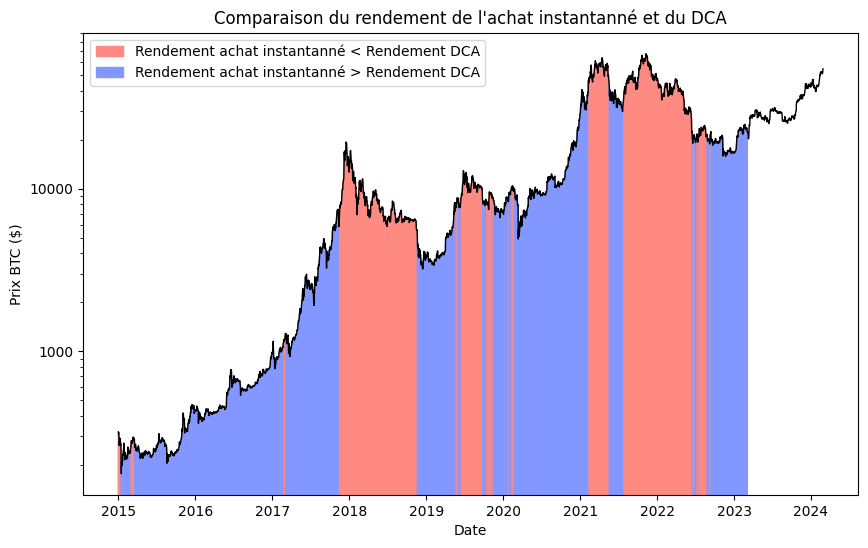

In [82]:
def format_func(value, tick_number):
    return f'{value:.0f}'

# Calculer les conditions de couleur
condition_greater = dca_df['return'] > dca_df['dca_return']
condition_equal = dca_df['return'] == dca_df['dca_return']

# Identifier les points de changement
change_points = condition_greater.ne(condition_greater.shift()) | condition_equal.ne(condition_equal.shift())

# Ajouter le premier et le dernier point
change_points.iloc[0] = True
change_points.iloc[-1] = True

plt.figure(figsize=(10, 6))
plt.plot(dca_df['time'], dca_df['open'], color='black', linewidth=1)
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

start_idx = 0
for end_idx in change_points[change_points].index:
    if condition_equal.iloc[start_idx]:
        fill_color = 'none'  # Pas de remplissage si return est égal à dca_return
    elif condition_greater.iloc[start_idx]:
        fill_color = '#8297ff'  # Bleu si return > dca_return
    else:
        fill_color = '#ff8a82'  # Rouge si return < dca_return

    plt.fill_between(dca_df['time'][start_idx:end_idx+1], dca_df['open'][start_idx:end_idx+1], color=fill_color)
    start_idx = end_idx

plt.title('Comparaison du rendement de l\'achat instantanné et du DCA')
plt.xlabel('Date')
plt.ylabel('Prix BTC ($)')

red_patch = mpatches.Patch(color='#ff8a82', label="Rendement achat instantanné < Rendement DCA")
blue_patch = mpatches.Patch(color='#8297ff', label="Rendement achat instantanné > Rendement DCA")
plt.legend(handles=[red_patch, blue_patch], loc='upper left')

plt.show()


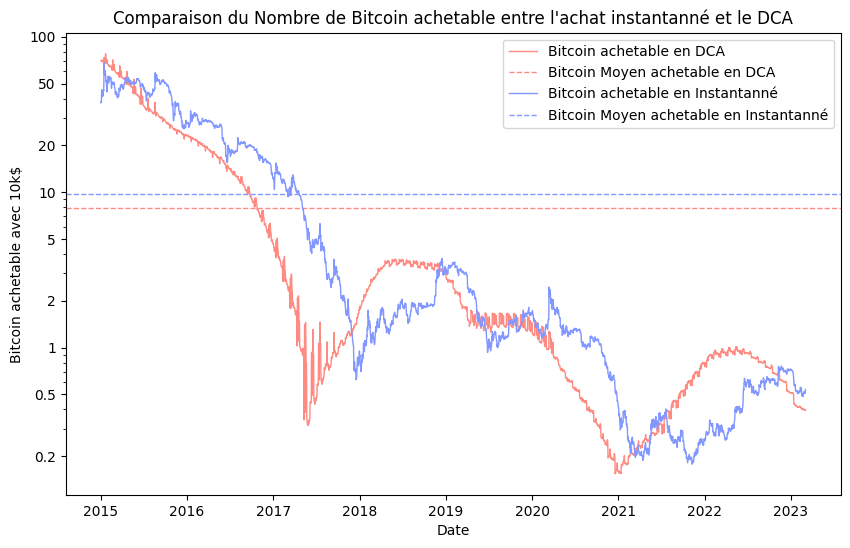

In [83]:
def format_func(value, tick_number):
    if value < 1:
        return f'{value:.1f}'
    else:
        return f'{value:.0f}'

plt.figure(figsize=(10, 6))
plt.yscale('log')

ticks = [0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]
plt.gca().yaxis.set_major_locator(FixedLocator(ticks))

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

plt.plot(dca_df['time'], dca_df['dca_quantity_buy'], color='#ff8a82', linewidth=1, label='Bitcoin achetable en DCA')
plt.axhline(y= dca_df['dca_quantity_buy'].mean(), color='#ff8a82', linestyle='--', linewidth=1, label='Bitcoin Moyen achetable en DCA')
plt.plot(dca_df['time'], dca_df['quantity_buy'], color='#8297ff', linewidth=1, label='Bitcoin achetable en Instantanné')
plt.axhline(y= dca_df['quantity_buy'].mean(), color='#8297ff', linestyle='--', linewidth=1, label='Bitcoin Moyen achetable en Instantanné')

plt.title('Comparaison du Nombre de Bitcoin achetable entre l\'achat instantanné et le DCA')
plt.xlabel('Date')
plt.ylabel('Bitcoin achetable avec 10k$')

plt.legend()

plt.show()


In [84]:
instant_buyable_btc = dca_df['quantity_buy'].mean()
dca_buyable_btc = dca_df['dca_quantity_buy'].mean()
buyable_diff = (instant_buyable_btc - dca_buyable_btc) / dca_buyable_btc * 100

time_dca = dca_df['dca_return_better'].value_counts(normalize=True)
time_instant_better = time_dca['Instant'] * 100
time_dca_better = time_dca['DCA'] * 100

dca_mean_return = dca_df['dca_return'].mean() * 100
instant_mean_return = dca_df['return'].mean() * 100

print(f"Quantité moyenne de BTC achetable instantannément: {instant_buyable_btc:.2f} BTC")
print(f"Quantité moyenne de BTC achetable avec DCA: {dca_buyable_btc:.2f} BTC")
print(f"Différence de quantité achetable: +{buyable_diff:.2f} %")
print(f"\nPourcentage de temps où l'achat instantanné est meilleur: {time_instant_better:.2f} %")
print(f"Pourcentage de temps où DCA est meilleur: {time_dca_better:.2f} %")
print(f"\nRendement moyen de l'achat instantanné: +{instant_mean_return:.2f} %")
print(f"Rendement moyen de DCA: +{dca_mean_return:.2f} %")


Quantité moyenne de BTC achetable instantannément: 9.76 BTC
Quantité moyenne de BTC achetable avec DCA: 7.89 BTC
Différence de quantité achetable: +23.73 %

Pourcentage de temps où l'achat instantanné est meilleur: 65.23 %
Pourcentage de temps où DCA est meilleur: 34.77 %

Rendement moyen de l'achat instantanné: +3867.83 %
Rendement moyen de DCA: +2974.15 %
